In [75]:
import torch
from transformers import ViTImageProcessor, ViTForImageClassification
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np

In [76]:
def viewBatch(model, batch):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    outputs = model(batch.to(device))
    val, idx = torch.max(outputs.logits, dim=1)
    idx = idx.tolist()

    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))  # Create a 4x4 grid of subplots
    axes = axes.flatten()  # Flatten the 2D array of axes into 1D for easier iteration

    for i, (img, id) in enumerate(zip(batch[:16], idx[:16])):
        img = img.cpu().numpy().transpose((1, 2, 0))  # Convert tensor to numpy and change C, H, W to H, W, C
        img = np.clip(img, 0, 1)  # Ensure pixel values are valid for display
        axes[i].imshow(img)
        labels = model.config.id2label[id]
        axes[i].set_title(f'Classification: {labels.split(",")[0]}')  # Set the title to the label of the image
        axes[i].axis('off')  # Turn off axis numbers and ticks

    plt.tight_layout()  # Adjust layout to make room for titles and ensure plots don't overlap
    plt.show()

In [77]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224').to(device)
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
model.eval()
torch.no_grad()

c:\Projects\AdvAttack\.conda\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [78]:
def process_image(image):
    return processor(image, return_tensors="pt").pixel_values.squeeze(0)

dataIN = datasets.ImageFolder('./imagenette', transform=transforms.Lambda(process_image))
# Note, DataLoader breaks with num_workers > 0
dataLoader = torch.utils.data.DataLoader(dataIN,
                                          batch_size=16,
                                          shuffle=True,
                                          num_workers=0)

In [79]:
#viewBatch(model, dataLoader)

# Large Scale Adversarial Generation

In [80]:
from captum.robust import FGSM, MinParamPerturbation

In [81]:
def pred(inputs, model):
  outputs = model(inputs)
  logits = outputs.logits
  val, idx = torch.max(logits, dim=1)
  #idx = idx.tolist()
  return idx

In [82]:
def fgsmAttack(inputs, model, true_label, epsilon=0.1):
  # Wrapper of the model that outputs logits - needed for FGSM.perturb
  forward_func = lambda *args, **kwargs: model(*args, **kwargs).logits
  fgsm = FGSM(forward_func, lower_bound=-1, upper_bound=1)
  return fgsm.perturb(inputs, epsilon=epsilon, target=true_label)

In [83]:
adversarialBatch = None
inputs = None
for inputs, labels in dataLoader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    labels = pred(inputs, model)
    adversarialBatch = fgsmAttack(inputs, model, labels, epsilon = 0.1)
    break

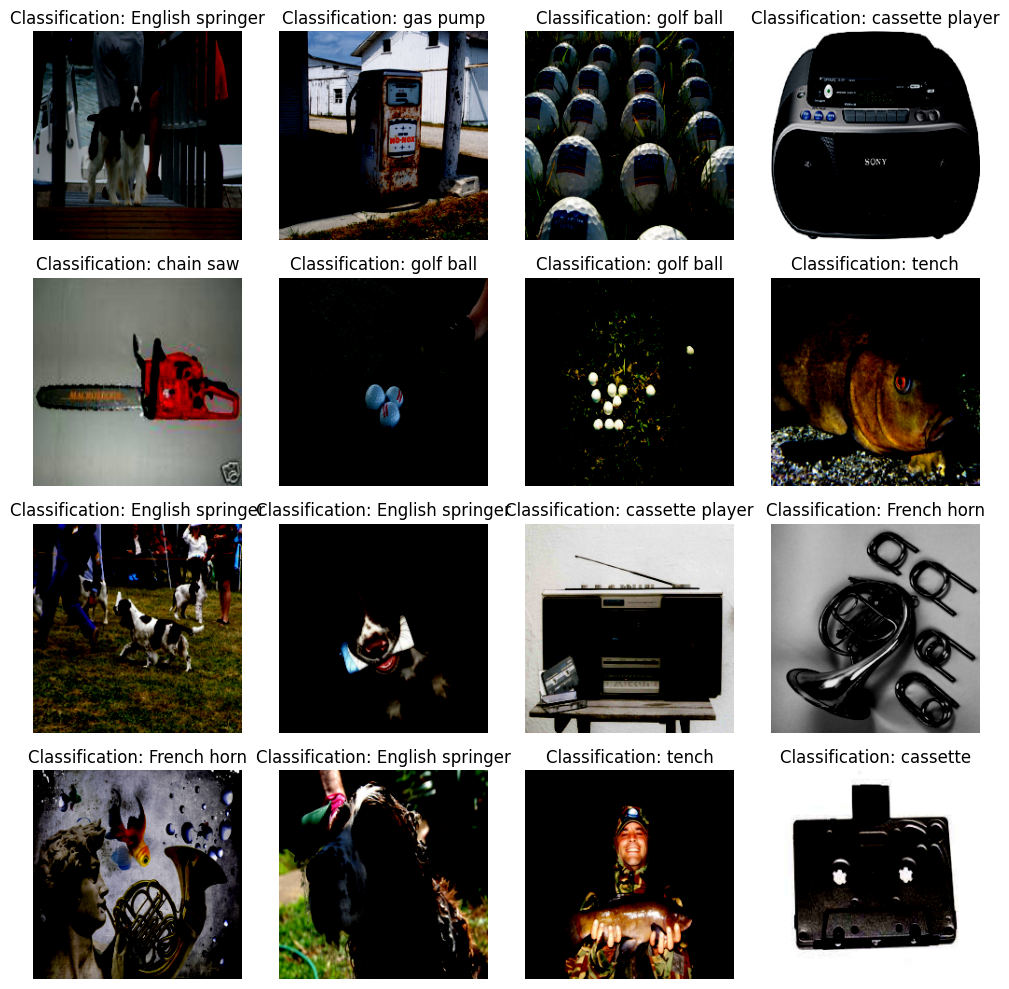

In [84]:
viewBatch(model, inputs)

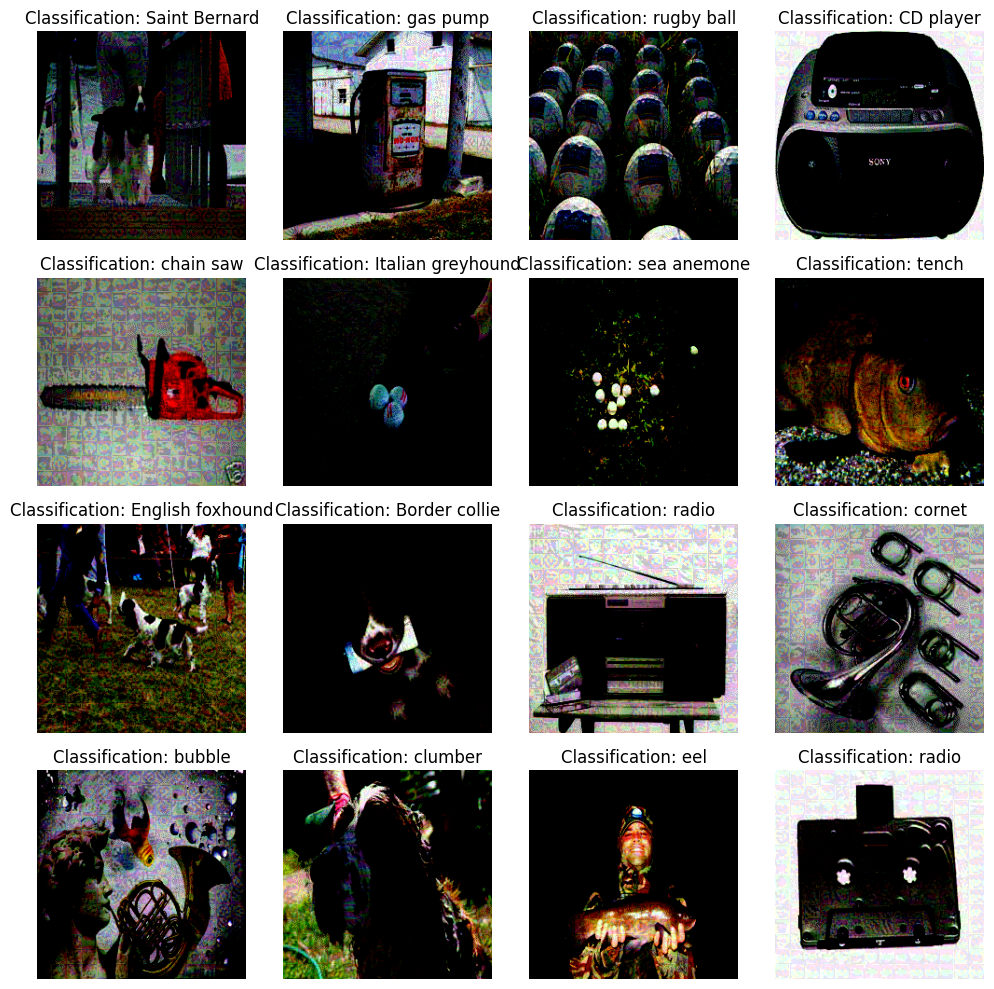

In [85]:
viewBatch(model, adversarialBatch)

In [86]:
import os
path_adversarial_dataset = "./data_adv"
os.makedirs(path_adversarial_dataset, exist_ok=True)

In [96]:
min_pert = MinParamPerturbation(
                                forward_func = lambda *args, **kwargs: model(*args, **kwargs).logits,
                                attack = fgsmAttack,
                                arg_name = 'epsilon',
                                mode = "linear",
                                arg_min = 0.001,
                                arg_max = 0.1,
                                arg_step = 0.001#,
                                #preproc_fn = processor,
                                #apply_before_preproc=False
                               )

alt_im, min_eps, inputs = None, None, None

for inputs, labels in dataLoader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    labels = pred(inputs, model)
    attack_kwargs={'model':model,'true_label':labels}

    alt_im, min_eps = min_pert.evaluate(inputs, attack_kwargs=attack_kwargs, target=labels)
    break


does evaluate allow for batched calc? only returns single min_eps?

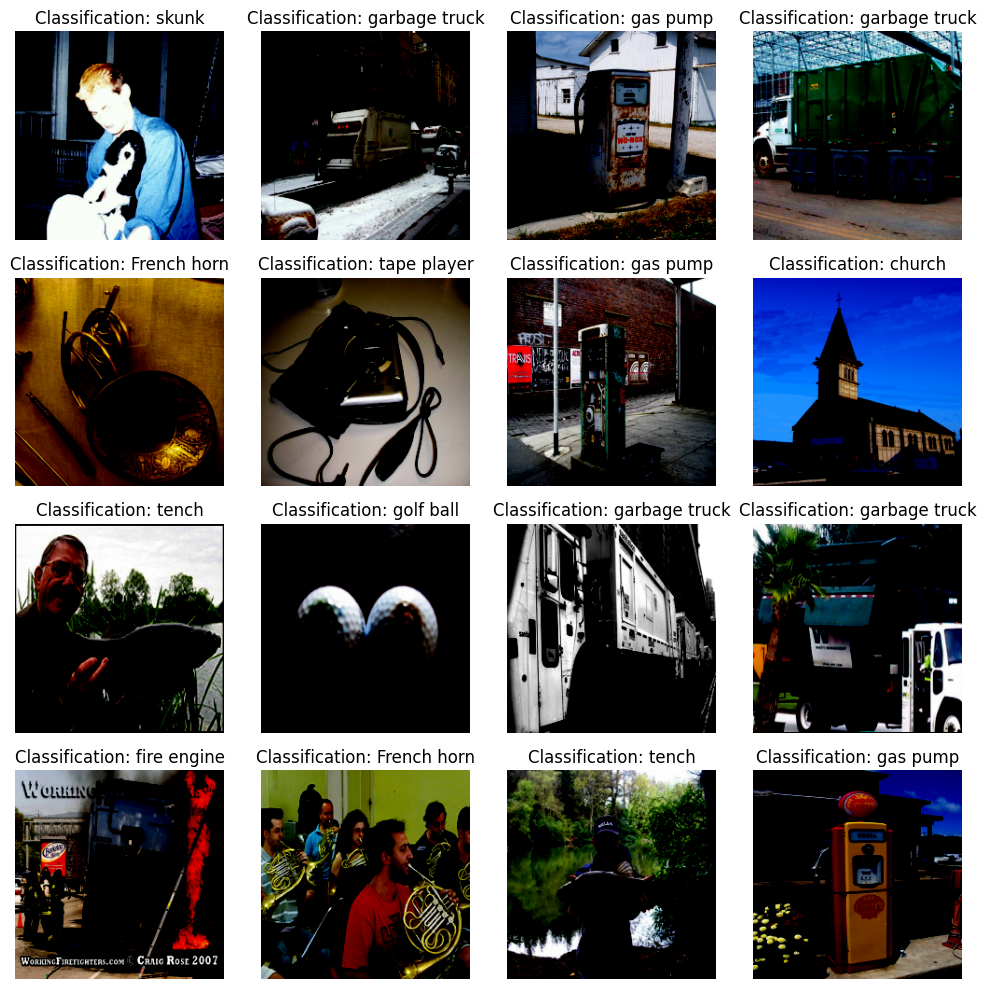

In [93]:
viewBatch(model, inputs)

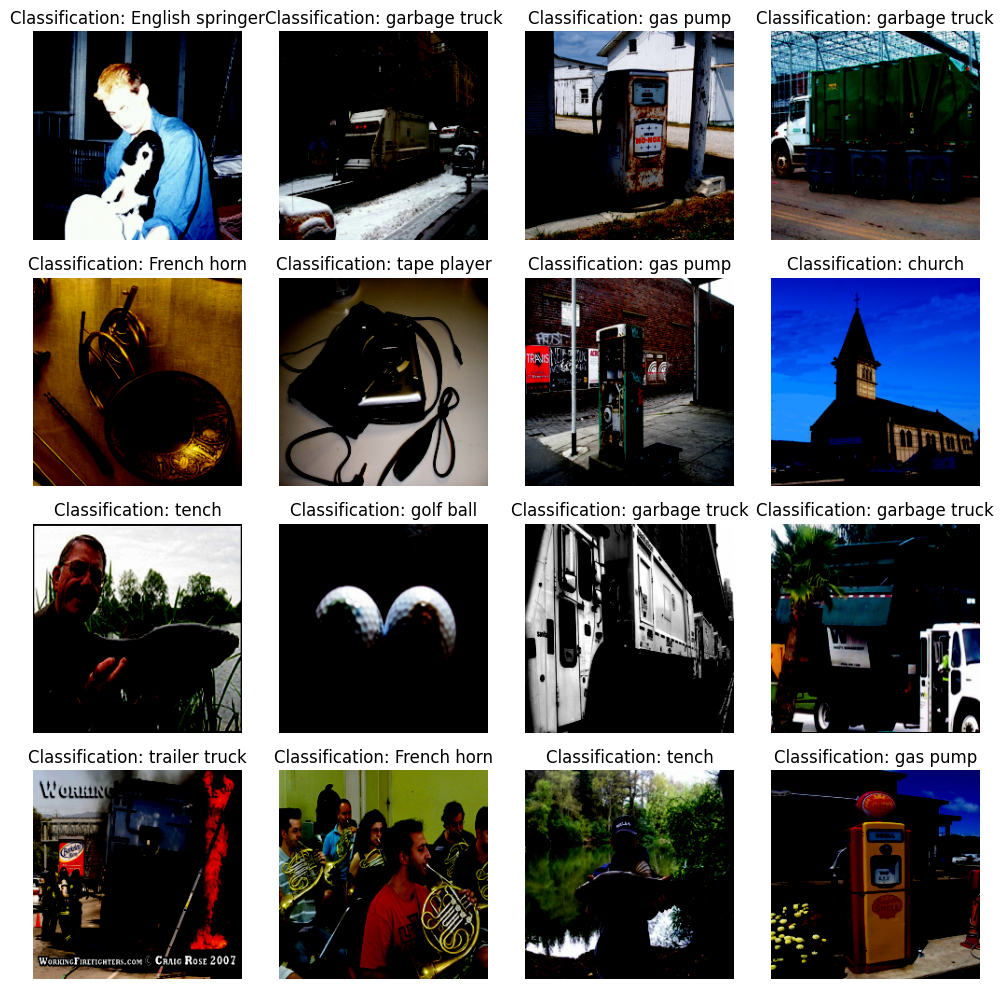

In [94]:
viewBatch(model, alt_im)